In [1]:
# Install required packages
import sys, os
import numpy as np
import scipy.spatial as sp
from sklearn.preprocessing import normalize
from IPython.display import display, clear_output
from IPython.display import Markdown
import pandas as pd
from collections import namedtuple
from itertools import product, permutations
import matplotlib.pyplot as plt
import random
import copy

# Import pyomo environment and setup gurobi solver
import pyomo.environ as pyo
import gurobipy 
solver = pyo.SolverFactory("gurobi_direct")

In [2]:
'''
Sample pertubations of instance
Args:     orig          - array of original instance
          index_list    - list with indices of originial array to perturb
          method        - method to perturb instance. Only option now: normal
          var           - variance for pertubation
          size          - number of perturbed instances
Output:   org_plus_smpl - array with rows original instance and size perturbed instances
'''

def sample_perturbations(orig, index_list, method = 'normal', var = 0.2, size = 1000):
    
    mean = 0
    org_plus_prtb = []
    org_plus_prtb.append(orig)
    
    for i in range(size):
        orig_with_noise = copy.deepcopy(orig)
        
        for j in range(len(orig)):
            if j in index_list:
                sigma = orig_with_noise[j] * var
                orig_with_noise[j] = orig_with_noise[j] + np.random.normal(mean, sigma)
    
        org_plus_prtb.append(np.asarray(orig_with_noise))
    org_plus_prtb = np.asarray(org_plus_prtb)

    return org_plus_prtb

In [3]:
# Compute distance between two vectors and evaluate the kernel function
# kernel_width: kernel width for the exponential kernel.
#                 If None, defaults to sqrt (number of columns) * 0.75

def distance(a, b):
    return np.linalg.norm(a - b)
    
def kernel(a, b, index_list, kernel_width = None):
    d = distance(a, b)
    if kernel_width is None:
        kernel_width = np.sqrt(len(index_list)) * .75

    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

In [4]:
# Create instances for Knapsack problem


# Instance 1: with logical features
KS_wgts_1 = [0.9, 0.02, 0.03, 0.01, 0.04, 0.005, 0.001, 0.015, 0.09, 0.0001]
KS_vals_1 = [9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 6]
KS_bdgt_1 = 1
# Concatenate variables
inst_1 = np.concatenate((KS_vals_1, KS_wgts_1, [KS_bdgt_1]))

# Instance 2: with correlated weights and values
KS_wgts_2 = [0.09, 0.2 , 0.3 , 0.1  , 0.4  , 0.05  , 0.01, 0.15 , 0.19 , 0.01]
KS_vals_2 = [0.1 , 0.21, 0.39, 0.101, 0.398, 0.0507, 0.01, 0.146, 0.188, 0.017]
KS_bdgt_2 = 1
# Concatenate variables
inst_2 = np.concatenate((KS_vals_2, KS_wgts_2, [KS_bdgt_2]))

# Instance 3: Random instance
np.random.seed(10)
KS_wgts_3_tmp = np.random.rand(10)
KS_wgts_3 = KS_wgts_3_tmp / (0.9 * np.sum(KS_wgts_3_tmp))
KS_vals_3 = np.random.rand(10)
KS_bdgt_3 = 1
# Concatenate variables
inst_3 = np.concatenate((KS_vals_3, KS_wgts_3, [KS_bdgt_3]))

In [5]:
# Binary LP knapsack
def model_KS_bin(vals, solver = solver):

    # Define a model
    model = pyo.ConcreteModel('Test KS')

    # Declare decision variables
    model.x = pyo.Var(range(len(KS_wgts_1)), domain=pyo.Binary)

    # Declare objective
    model.objective = pyo.Objective(expr = sum(vals[i]*model.x[i] for i in range(len(KS_wgts_1))),
                                sense = pyo.maximize)

    # Declare constraints
    model.budget = pyo.Constraint(expr = sum(vals[i+len(KS_wgts_1)]*model.x[i] for i in range(len(KS_wgts_1))) <= vals[-1])

    # Solve
    result = solver.solve(model)

    # Store solutions
    solutions = []
    for i in range(len(KS_wgts_1)):
        solutions.append(pyo.value(model.x[i]))

    return model.objective(), solutions

In [6]:
# Continuous LP knapsack
def model_KS_cts(vals, solver = solver):

    # Define a model
    model = pyo.ConcreteModel('Test KS')

    # Declare decision variables
    model.x = pyo.Var(range(len(KS_wgts_1)), domain=pyo.NonNegativeReals, bounds=(0, 1))

    # Declare objective
    model.objective = pyo.Objective(expr = sum(vals[i]*model.x[i] for i in range(len(KS_wgts_1))),
                                    sense = pyo.maximize)

    # Declare constraints
    model.budget = pyo.Constraint(expr = sum(vals[i+len(KS_wgts_1)]*model.x[i] for i in range(len(KS_wgts_1))) <= vals[-1])

    # Solve
    result = solver.solve(model)

    # Store solutions
    solutions = []
    for i in range(len(KS_wgts_1)):
        solutions.append(pyo.value(model.x[i]))

    return model.objective(), solutions

In [7]:
# Heuristic for Knapsack

def model_KS_hrs(vals, solver = solver):

    # Sort ratios
    arr = []
    for i in range(0, len(KS_wgts_1)):
        arr.append([vals[i], vals[i+len(KS_wgts_1)], i])

    arr.sort(key=lambda x: (x[0]/x[1]), reverse=True)

    # Result(value in Knapsack)
    finalvalue = 0.0
    W = vals[-1]
    solutions = np.zeros(len(KS_wgts_1))

    # Looping through all Items
    for item in arr:
    # If adding Item won't overflow, add it completely
        if item[1] <= W:
            W -= item[1]
            finalvalue += item[0]
            solutions[item[2]] = 1

        else:
            break

    # Returning final value and solution
    return finalvalue, solutions

In [8]:
# Print outcome of the three models applied to instance 1

print(model_KS_bin(inst_1))
print(model_KS_cts(inst_1))
print(model_KS_hrs(inst_1))

(18.0, [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, -0.0, 1.0])
(18.288999999999998, [0.9765555555555554, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0])
(9.5, array([0., 1., 1., 1., 1., 1., 1., 1., 0., 1.]))


In [9]:
# Create labels for features of instances
# Features for now: 

labels = []
for i in range(len(KS_wgts_1)):
    labels.append(('Value_'+str(i)))
for i in range(len(KS_vals_1)):
    labels.append(('Weight_'+str(i)))

labels.append('Budget')

features = [*range(20)]

In [10]:
# Create perturbations of instance 1
smpl_1 = sample_perturbations(inst_1, features)

# Array of weights given by the kernel function (distance wrt original instance)
wgts_1 = []

# Arrays for storing solutions for perturbed values
sol_bin_1 = []
sol_cts_1 = []
sol_hrs_1 = []

# Arrays for storing objective value for perturbed values
opt_bin_1 = []
opt_cts_1 = []
opt_hrs_1 = []

for smpl in smpl_1:
    wgts_1.append(kernel(smpl_1[0], smpl, features))
    
    full_sol_bin = model_KS_bin(smpl)
    full_sol_cts = model_KS_cts(smpl)
    full_sol_hrs = model_KS_hrs(smpl)

    opt_bin_1.append(full_sol_bin[0])
    opt_cts_1.append(full_sol_cts[0])
    opt_hrs_1.append(full_sol_hrs[0])

    sol_bin_1.append(full_sol_bin[1])
    sol_cts_1.append(full_sol_cts[1])
    sol_hrs_1.append(full_sol_hrs[1])

In [11]:
# Initial solutions
int_sol_bin_1 = model_KS_bin(inst_1)[1]
int_sol_cts_1 = model_KS_cts(inst_1)[1]
int_sol_hrs_1 = model_KS_hrs(inst_1)[1]

# Array checking whether original solution stays feasible
fsb_bin_1 = np.zeros(len(smpl_1))
fsb_cts_1 = np.zeros(len(smpl_1))
fsb_hrs_1 = np.zeros(len(smpl_1))

for i in range(len(smpl_1)):
    smpl = smpl_1[i]
    
    if np.dot(int_sol_bin_1, smpl[10:-1]) <= 1:
        fsb_bin_1[i] = 1
    if np.dot(int_sol_cts_1, smpl[10:-1]) <= 1:
        fsb_cts_1[i] = 1
    if np.dot(int_sol_hrs_1, smpl[10:-1]) <= 1:
        fsb_hrs_1[i] = 1

# Array checking whether original solution stays optimal
opt_bin_1 = np.zeros(len(smpl_1))
opt_cts_1 = np.zeros(len(smpl_1))
opt_hrs_1 = np.zeros(len(smpl_1))

for i in range(len(smpl_1)):
    if sol_bin_1[0] == sol_bin_1[i]:
        opt_bin_1[i] = 1
    if sol_cts_1[0] == sol_cts_1[i]:
        opt_cts_1[i] = 1
    if sol_hrs_1[0].all() == sol_hrs_1[i].all():
        opt_hrs_1[i] = 1


# Explaining optimality

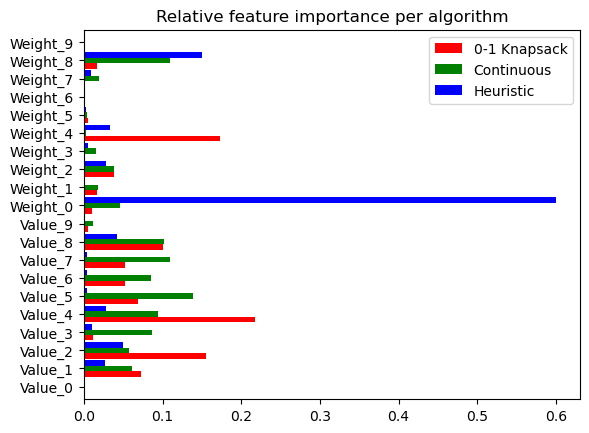

In [12]:
# Fit a linear ridge model to explain instance 1 for the different models

from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

clf_bin_1 = Ridge(alpha=1, fit_intercept=True)
clf_bin_1.fit(smpl_1[:,features], opt_bin_1, sample_weight=wgts_1)

clf_cts_1 = Ridge(alpha=1, fit_intercept=True)
clf_cts_1.fit(smpl_1[:,features], opt_cts_1, sample_weight=wgts_1)

clf_hrs_1 = Ridge(alpha=1, fit_intercept=True)
clf_hrs_1.fit(smpl_1[:,features], opt_hrs_1, sample_weight=wgts_1)

# Normalize coefficients to get feature importance
ftr_imp_bin_1 = np.abs(clf_bin_1.coef_)/np.sum(np.abs(clf_bin_1.coef_))
ftr_imp_cts_1 = np.abs(clf_cts_1.coef_)/np.sum(np.abs(clf_cts_1.coef_))
ftr_imp_hrs_1 = np.abs(clf_hrs_1.coef_)/np.sum(np.abs(clf_hrs_1.coef_))

# Plot feature importance
ind = np.arange(len(features))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp_bin_1, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, ftr_imp_cts_1, width, color='green', label='Continuous')
ax.barh(ind + 2*width, ftr_imp_hrs_1, width, color='blue', label='Heuristic')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[features], ylim=[2*width - 1, len(features)])
ax.legend()
plt.title('Relative feature importance per algorithm')
plt.show()

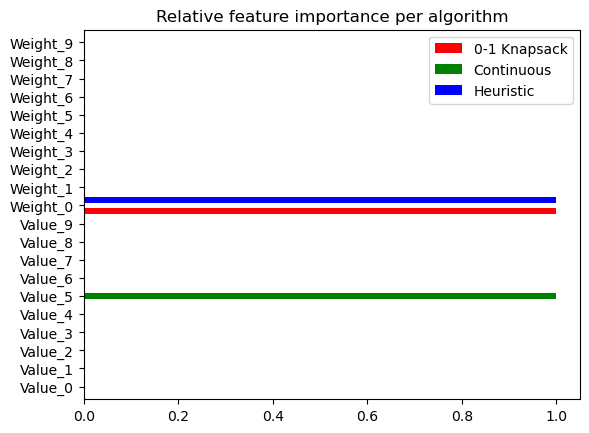

In [13]:
# Fit a regression tree. Hyperparameters are pragmatic chosen for now

from sklearn.tree import DecisionTreeRegressor

tree_bin_1 = DecisionTreeRegressor(random_state=0, max_depth=3,min_samples_leaf=100)
tree_bin_1.fit(smpl_1[:,features], opt_bin_1, sample_weight=wgts_1)

tree_cts_1 = DecisionTreeRegressor(random_state=0, max_depth=3,min_samples_leaf=100)
tree_cts_1.fit(smpl_1[:,features], opt_cts_1, sample_weight=wgts_1)

tree_hrs_1 = DecisionTreeRegressor(random_state=0, max_depth=3,min_samples_leaf=100)
tree_hrs_1.fit(smpl_1[:,features], opt_hrs_1, sample_weight=wgts_1)

# Plot feature importance of decision tree
ind = np.arange(len(features))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, tree_bin_1.feature_importances_, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, tree_cts_1.feature_importances_, width, color='green', label='Continuous')
ax.barh(ind + 2*width, tree_hrs_1.feature_importances_, width, color='blue', label='Heuristic')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[features], ylim=[2*width - 1, len(features)])
ax.legend()
plt.title('Relative feature importance per algorithm')
plt.show()

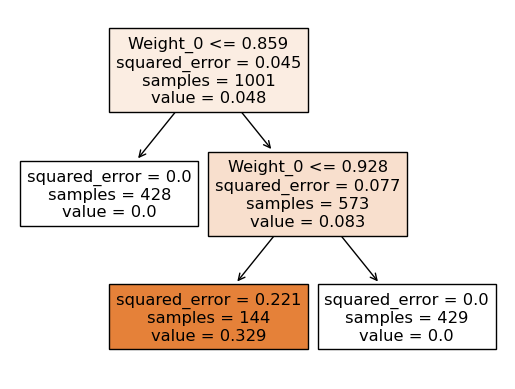

In [14]:
# Plot decision tree itself

from sklearn.tree import plot_tree

plt.figure()
plot_tree(tree_bin_1, filled=True, feature_names = labels)
plt.show()

# Explaining feasibility

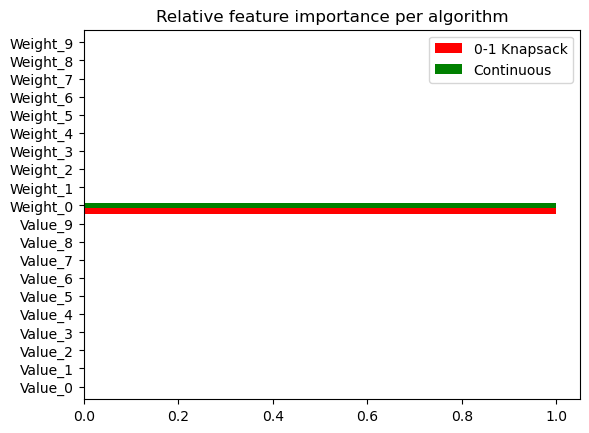

In [15]:
# Fit a classification tree on feasibility. Hyperparameters are pragmatic chosen for now
# For all samples of instance 1 the original solution found by the heuristic is feasible, hence fitting a classification model would not work here

from sklearn.tree import DecisionTreeClassifier

tree_bin_fsb_1 = DecisionTreeClassifier(random_state=0, max_depth=3,min_samples_leaf=100)
tree_bin_fsb_1.fit(smpl_1[:,features], fsb_bin_1, sample_weight=wgts_1)

tree_cts_fsb_1 = DecisionTreeClassifier(random_state=0, max_depth=3,min_samples_leaf=100)
tree_cts_fsb_1.fit(smpl_1[:,features], fsb_cts_1, sample_weight=wgts_1)

ind = np.arange(len(features))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, tree_bin_fsb_1.feature_importances_, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, tree_cts_fsb_1.feature_importances_, width, color='green', label='Continuous')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[features], ylim=[2*width - 1, len(features)])
ax.legend()
plt.title('Relative feature importance per algorithm')
plt.show()

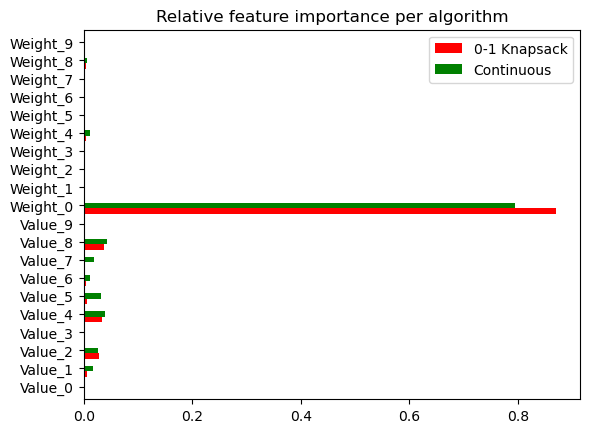

In [16]:
# Fit a log regression on wheter original solution remains feasibile
from sklearn.linear_model import LogisticRegression

logr_bin_fsb_1 = LogisticRegression(random_state=0)
logr_bin_fsb_1.fit(smpl_1[:,features], fsb_bin_1, sample_weight=wgts_1)

logr_cts_fsb_1 = LogisticRegression(random_state=0)
logr_cts_fsb_1.fit(smpl_1[:,features], fsb_cts_1, sample_weight=wgts_1)

# Normalize coefficients to get feature importance
logr_ftr_imp_bin_1 = np.abs(logr_bin_fsb_1.coef_[0])/np.sum(np.abs(logr_bin_fsb_1.coef_[0]))
logr_ftr_imp_cts_1 = np.abs(logr_cts_fsb_1.coef_[0])/np.sum(np.abs(logr_cts_fsb_1.coef_[0]))

# Plot feature importance
ind = np.arange(len(features))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, logr_ftr_imp_bin_1, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, logr_ftr_imp_cts_1, width, color='green', label='Continuous')
ax.set(yticks=ind + width, yticklabels=np.array(labels)[features], ylim=[2*width - 1, len(features)])
ax.legend()
plt.title('Relative feature importance per algorithm')
plt.show()

# Explaining optimal decision

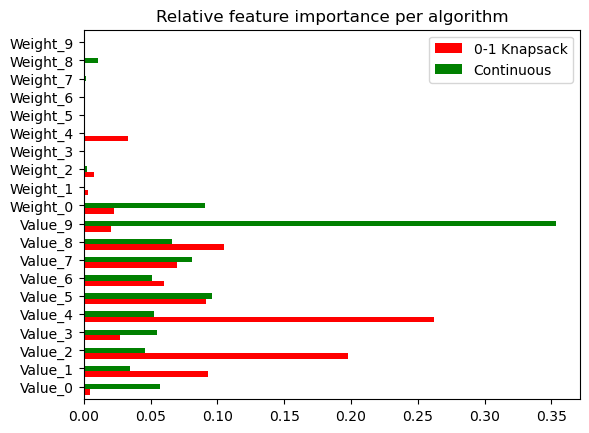

In [17]:
# Fit a log regression on wheter original solution remains optimal
from sklearn.linear_model import LogisticRegression

logr_bin_opt_1 = LogisticRegression(random_state=0)
logr_bin_opt_1.fit(smpl_1[:,features], opt_bin_1, sample_weight=wgts_1)

logr_cts_opt_1 = LogisticRegression(random_state=0)
logr_cts_opt_1.fit(smpl_1[:,features], opt_cts_1, sample_weight=wgts_1)

# Normalize coefficients to get feature importance
logr_ftr_imp_opt_bin_1 = np.abs(logr_bin_opt_1.coef_[0])/np.sum(np.abs(logr_bin_opt_1.coef_[0]))
logr_ftr_imp_opt_cts_1 = np.abs(logr_cts_opt_1.coef_[0])/np.sum(np.abs(logr_cts_opt_1.coef_[0]))

# Plot feature importance
ind = np.arange(len(features))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, logr_ftr_imp_opt_bin_1, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, logr_ftr_imp_opt_cts_1, width, color='green', label='Continuous')
ax.set(yticks=ind + width, yticklabels=np.array(labels)[features], ylim=[2*width - 1, len(features)])
ax.legend()
plt.title('Relative feature importance per algorithm')
plt.show()